In [1]:
import random
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join

from skimage.io import imshow, imread
from skimage.transform import resize

from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.core import Lambda, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.initializers import RandomNormal
from keras import backend as K

# Utils

In [2]:
HEIGHT = 72
WIDTH = 128

In [3]:
def plot_image(image):
    print(image.shape)
    imshow(image)
    plt.show()

# Load Data

In [4]:
def load_images_from_files(path, images_files, *, height, width):
    images = []
    for file in tqdm.tqdm(images_files):
        img = imread(path + file)
        img_resized = resize(img, (height, width))
        images.append({"file": file, "image": img_resized[:, :, :3]})
        
    return pd.DataFrame.from_dict(images)

def load_images_from_path(path, n_images):
    images_files = [file for file in listdir(path) if isfile(join(path, file))]
    return load_images_from_files(path, images_files[:n_images], height=HEIGHT, width=WIDTH)

## Load Train & Val Data

In [5]:
N_IMAGES_TRAIN_VAL = 1370
N_IMAGES_VAL = 70
path = '../Datasets/KaggleSatellite/'
train_val_images_df = load_images_from_path(path, N_IMAGES_TRAIN_VAL)

train_images_df = train_val_images_df[:-N_IMAGES_VAL]
val_images_df = train_val_images_df[:N_IMAGES_VAL]

print('%d images for Training' % len(train_images_df))
print('%d images for Validating'% len(val_images_df))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1370/1370 [1:12:49<00:00,  3.19s/it]

1300 images for Training
70 images for Validating


In [6]:
print('%d images for Training' % len(train_images_df))
print('%d images for Validating'% len(val_images_df))

1300 images for Training
70 images for Validating


### Plot Examples

Train Data
(72, 128, 3)


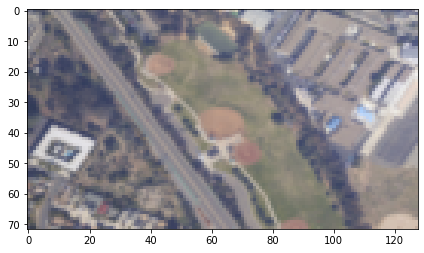

In [7]:
print("Train Data")
idx = random.randint(0, len(train_images_df) - 1)
plot_image(train_images_df.loc[idx].image)

Validation Data
(72, 128, 3)


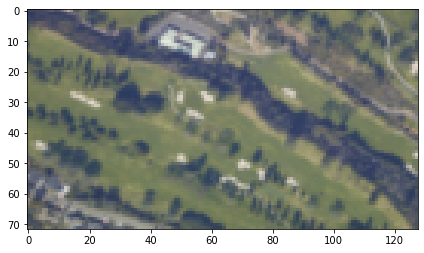

In [8]:
print("Validation Data")
idx = random.randint(0, len(val_images_df) - 1)
plot_image(val_images_df.loc[idx].image)

## Load Test Data

In [9]:
N_IMAGES_TEST = 12
N_GLOBAL_MAPS = 6

path = '../Datasets/DroneImages/DatasetImageSimilarity/drone/'
test_images_drone_df = load_images_from_path(path, N_IMAGES_TEST)

path = '../Datasets/DroneImages/DatasetImageSimilarity/globalmap'
test_images_globalmap_dfs = [load_images_from_path(path + str(i + 1) + '/', N_IMAGES_TEST) for i in range(N_GLOBAL_MAPS)]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.18it/s]


### Plot Examples

Test Data
(72, 128, 3)


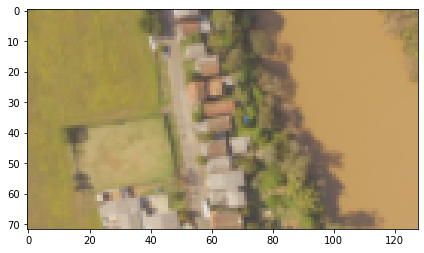

(72, 128, 3)


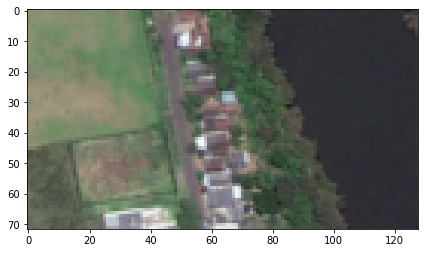

In [11]:
print("Test Data")
idx = random.randint(0, len(test_images_drone_df) - 1)
globalmap_idx = random.randint(0, N_GLOBAL_MAPS - 1)
plot_image(test_images_drone_df.loc[idx].image)
plot_image(test_images_globalmap_dfs[globalmap_idx].loc[idx].image)

# Assemble Datasets

## Train & Val

In [12]:
N_ITEMS_PER_EXAMPLE = 5

EXAMPLE_IDX = 3 # Example means the location the picture was taken
ITEM_IDX = -6 # Item means one of the pictures taken from the location

def _get_example(row):
    return int(row.file.split('_')[0][EXAMPLE_IDX:])


def _get_file(example, item):
    return 'set' + str(example) + '_' + str(item) + '.jpeg'


def _insert_similar_examples_for_satellite(images_df, left_inputs, right_inputs, targets, row):
    for item in range(1, N_ITEMS_PER_EXAMPLE + 1):
        if item == int(row.file[ITEM_IDX]): # Make sure we are not comparing to the same item
            continue
        
        right_file = _get_file(_get_example(row), item)

        left_inputs.append(row.image)
        right_inputs.append(images_df[images_df.file == right_file].image.values[0])
        targets.append(1)   
        
    
def _insert_different_examples_for_satellite(images_df, left_inputs, right_inputs, targets, row):
    for _ in range(N_ITEMS_PER_EXAMPLE - 1):
        right_example = _get_example(images_df.loc[random.randint(0, len(images_df) - 1)])
        while right_example == _get_example(row): # Make sure we are not comparing to the same example
            right_example = _get_example(images_df.loc[random.randint(0, len(images_df) - 1)])
            
        right_file = _get_file(right_example, random.randint(1, 5))

        left_inputs.append(row.image)
        right_inputs.append(images_df[images_df.file == right_file].image.values[0])
        targets.append(0)
        

def generate_dataset_from_satellite_images(df):
    left_inputs = []
    right_inputs = []
    targets = []

    for _, row in tqdm.tqdm(df.iterrows()):
        _insert_similar_examples_for_satellite(df, left_inputs, right_inputs, targets, row)
        _insert_different_examples_for_satellite(df, left_inputs, right_inputs, targets, row)
        
    left_inputs = np.squeeze(np.array(left_inputs))
    right_inputs = np.squeeze(np.array(right_inputs))
    targets = np.squeeze(np.array(targets))
        
    return left_inputs, right_inputs, targets

In [13]:
train_left_inputs, train_right_inputs, train_targets = generate_dataset_from_satellite_images(train_images_df)
val_left_inputs, val_right_inputs, val_targets = generate_dataset_from_satellite_images(val_images_df)

print('%d Examples for Training' % len(train_targets))
print('%d Examples for Validating' % len(val_targets))

1300it [00:08, 155.07it/s]
70it [00:00, 138.03it/s]


10400 Examples for Training
560 Examples for Validating


## Test

In [14]:
def _insert_similar_examples_for_drone_and_globalmap(globalmap_dfs, left_inputs, right_inputs, targets, row):
    for df in globalmap_dfs:
        left_inputs.append(row.image)
        right_inputs.append(df[df.file == row.file].image.values[0])
        targets.append(1)
    
def _insert_different_examples_for_drone_and_globalmap(globalmap_dfs, left_inputs, right_inputs, targets, row):
    for df in globalmap_dfs:
        right_input = df.loc[random.randint(0, len(df) - 1)]
        while right_input.file == row.file: # Make sure we are not comparing to the same example
            right_input = df.loc[random.randint(0, len(df) - 1)]
            
        left_inputs.append(row.image)
        right_inputs.append(right_input.image)
        targets.append(0)

def generate_dataset_from_drone_and_globalmap_images(drone_df, globalmap_dfs):
    left_inputs = []
    right_inputs = []
    targets = []

    for _, row in tqdm.tqdm(drone_df.iterrows()):
        _insert_similar_examples_for_drone_and_globalmap(globalmap_dfs, left_inputs, right_inputs, targets, row)
        _insert_different_examples_for_drone_and_globalmap(globalmap_dfs, left_inputs, right_inputs, targets, row)
        
    left_inputs = np.squeeze(np.array(left_inputs))
    right_inputs = np.squeeze(np.array(right_inputs))
    targets = np.squeeze(np.array(targets))
        
    return left_inputs, right_inputs, targets

In [15]:
test_left_inputs, test_right_inputs, test_targets = \
    generate_dataset_from_drone_and_globalmap_images(test_images_drone_df, test_images_globalmap_dfs)

print('%d Examples for Testing' % len(test_targets))

12it [00:00, 143.24it/s]

144 Examples for Testing


# Define Model

In [16]:
def get_siamese_model(input_shape):
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
        
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(filters=5, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(filters=5, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(filters=7, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(filters=7, kernel_size=(2, 2), activation='relu'))
    model.add(Flatten())
    model.add(Dense(18, activation='sigmoid'))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1, activation='sigmoid', bias_initializer=RandomNormal(mean=0.5, stddev=1e-2))(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)
    
    # return the model
    return siamese_net

In [17]:
model = get_siamese_model(train_images_df.loc[0].image.shape)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 72, 128, 3)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 72, 128, 3)] 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 18)           10566       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 18)           0           sequential[0][0]      

In [18]:
optimizer = Adam(lr=0.001, decay=2.5e-4)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])

# Train

In [19]:
model.fit([train_left_inputs, train_right_inputs], train_targets,
          batch_size=16,
          epochs=100,
          verbose=1,
          validation_data=([val_left_inputs, val_right_inputs], val_targets))

Epoch 1/100
650/650 [==============================] - 40s 62ms/step - loss: 0.4588 - accuracy: 0.8260 - val_loss: 0.4294 - val_accuracy: 0.8411
Epoch 2/100
650/650 [==============================] - 38s 59ms/step - loss: 0.3453 - accuracy: 0.8961 - val_loss: 0.3561 - val_accuracy: 0.8714
Epoch 3/100
650/650 [==============================] - 37s 57ms/step - loss: 0.2962 - accuracy: 0.9036 - val_loss: 0.3396 - val_accuracy: 0.8714
Epoch 4/100
650/650 [==============================] - 37s 57ms/step - loss: 0.2666 - accuracy: 0.9123 - val_loss: 0.3223 - val_accuracy: 0.8732
Epoch 5/100
650/650 [==============================] - 37s 58ms/step - loss: 0.2466 - accuracy: 0.9157 - val_loss: 0.2929 - val_accuracy: 0.8786
Epoch 6/100
650/650 [==============================] - 38s 58ms/step - loss: 0.2290 - accuracy: 0.9220 - val_loss: 0.2970 - val_accuracy: 0.8893
Epoch 7/100
650/650 [==============================] - 37s 58ms/step - loss: 0.2153 - accuracy: 0.9274 - val_loss: 0.3249 - val_ac

650/650 [==============================] - 38s 58ms/step - loss: 0.0613 - accuracy: 0.9886 - val_loss: 0.1850 - val_accuracy: 0.9214
Epoch 58/100
650/650 [==============================] - 39s 60ms/step - loss: 0.0605 - accuracy: 0.9886 - val_loss: 0.1981 - val_accuracy: 0.9179
Epoch 59/100
650/650 [==============================] - 38s 58ms/step - loss: 0.0595 - accuracy: 0.9890 - val_loss: 0.1987 - val_accuracy: 0.9125
Epoch 60/100
650/650 [==============================] - 40s 62ms/step - loss: 0.0587 - accuracy: 0.9892 - val_loss: 0.2067 - val_accuracy: 0.9089
Epoch 61/100
650/650 [==============================] - 38s 58ms/step - loss: 0.0584 - accuracy: 0.9899 - val_loss: 0.1916 - val_accuracy: 0.9161
Epoch 62/100
650/650 [==============================] - 40s 62ms/step - loss: 0.0577 - accuracy: 0.9887 - val_loss: 0.1840 - val_accuracy: 0.9232
Epoch 63/100
650/650 [==============================] - 38s 59ms/step - loss: 0.0569 - accuracy: 0.9890 - val_loss: 0.1802 - val_accuracy

# Compute Test Predictions

In [20]:
def predict_dataset(left_inputs, right_inputs, targets):
    predictions = ((model.predict([left_inputs, right_inputs]) > 0.5) * 1).reshape(-1)
    print('Accuracy is %.2f%%' % (np.mean(predictions == targets) * 100))
    
    return predictions

def predict_random_example(left_inputs, right_inputs, targets):
    idx = random.randint(0, len(targets) - 1)
    prediction = (model.predict([left_inputs[idx].reshape(1, 72, 128, 3), 
                                 right_inputs[idx].reshape(1, 72, 128, 3)]) > 0.5).reshape(-1)[0]
    print('Are images similar?', prediction)
    print()
    plot_image(left_inputs[idx])
    plot_image(right_inputs[idx])
    
    return prediction

In [21]:
predictions = predict_dataset(test_left_inputs, test_right_inputs, test_targets)

Accuracy is 54.86%


Are images similar? True

(72, 128, 3)


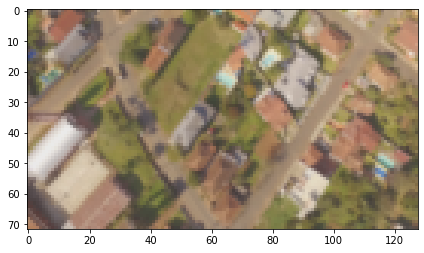

(72, 128, 3)


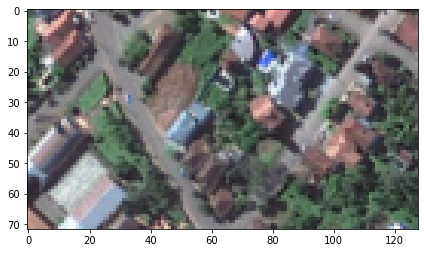

In [32]:
prediction = predict_random_example(test_left_inputs, test_right_inputs, test_targets)

Done!